# Model Validation

I want to check if my model is working well before I proceed with sentiment analysis.

This is an unsupervised model, so I will have to manually sample, label, and verify.

In [460]:
import bbcode
import re
import string
import spacy
import json

import nltk

import gensim
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, similarities

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import steamreviews
import datetime

In [7]:
#initialise model and dataset

#load dataset, which was previously cleaned in Modelling 3rd Run
model2_df = pd.read_csv('./dataframes/model2_df.csv',index_col=0)

#reload model
lda_model = LdaMulticore.load('./models/nouns_only/saved_model/saved.model')

C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open

In [8]:
model_topics = lda_model.show_topics(formatted=False)
for line in lda_model.print_topics(num_words=15):
    print(str(line)+'\n')

(0, '0.023*"three_kingdoms" + 0.023*"series" + 0.021*"fan" + 0.020*"diplomacy" + 0.020*"battle" + 0.018*"love" + 0.018*"best_total_war" + 0.017*"campaign" + 0.014*"total_war_games" + 0.014*"fun" + 0.014*"character" + 0.014*"shogun" + 0.014*"play" + 0.011*"title" + 0.009*"gameplay"')

(1, '0.025*"china" + 0.021*"war" + 0.021*"cao_cao" + 0.019*"lu_bu" + 0.016*"liu_bei" + 0.016*"yuan_shao" + 0.014*"army" + 0.011*"character" + 0.011*"man" + 0.010*"emperor" + 0.010*"warlord" + 0.010*"friend" + 0.010*"history" + 0.009*"faction" + 0.009*"sun_jian"')

(2, '0.037*"faction" + 0.027*"army" + 0.024*"diplomacy" + 0.016*"vassal" + 0.015*"war" + 0.014*"player" + 0.013*"people" + 0.012*"way" + 0.011*"city" + 0.011*"problem" + 0.011*"campaign" + 0.010*"option" + 0.009*"spy" + 0.009*"three_kingdoms" + 0.009*"review"')

(3, '0.053*"unit" + 0.035*"battle" + 0.026*"faction" + 0.023*"army" + 0.022*"general" + 0.022*"character" + 0.013*"diplomacy" + 0.013*"campaign" + 0.011*"hero" + 0.010*"building" + 0.010*

In [9]:
model2_df.head()

,timestamp_created,review,clean_reviews,3gram_reviews,3grams_nouns,3grams_nouns_verbs,3grams_nouns_v2,3grams_nouns_verbs_v2
0,1562590376,Well for me game still tons of work. i like it...,"['tons', 'work', 'recommend', 'one', 'diplomac...","['tons', 'work', 'recommend', 'one', 'diplomac...","['ton', 'diplomacy', 'joke', 'military_access'...","['ton', 'work', 'recommend', 'diplomacy', 'jok...","['ton', 'diplomacy', 'joke', 'military_access'...","['ton', 'work', 'recommend', 'diplomacy', 'jok..."
1,1562581870,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,"['pursued', 'lu', 'bu', 'lu', 'bu']","['pursued', 'lu_bu', 'lu_bu']","['lu_bu', 'lu_bu']","['pursue', 'lu_bu', 'lu_bu']","['lu_bu', 'lu_bu']","['pursue', 'lu_bu', 'lu_bu']"
2,1562578221,Absolutely great game. \nAll the new diplomacy...,"['absolutely', 'new', 'diplomacy', 'options', ...","['absolutely', 'new', 'diplomacy_options', 'de...","['diplomacy_options', 'depth', 'unit_variety',...","['diplomacy_options', 'depth', 'unit_variety',...","['diplomacy_options', 'depth', 'unit_variety',...","['diplomacy_options', 'depth', 'unit_variety',..."
3,1562575368,A fine blend of Warhammer I/II: Total War and ...,"['fine', 'blend', 'warhammer', 'two', 'total',...","['fine', 'blend', 'warhammer_two', 'total_war'...","['blend', 'warhammer_two', 'total_war', 'shogu...","['blend', 'warhammer_two', 'total_war', 'shogu...","['blend', 'warhammer_two', 'shogun_two', 'pro'...","['blend', 'warhammer_two', 'shogun_two', 'come..."
4,1562568222,Innovative Total Game that has lots of persona...,"['innovative', 'total', 'lots', 'personality',...","['innovative', 'total', 'lots', 'personality',...","['personality', 'diplomacy', 'idea', 'combat',...","['personality', 'bring', 'diplomacy', 'idea', ...","['personality', 'diplomacy', 'idea', 'combat',...","['personality', 'bring', 'diplomacy', 'idea', ..."


In [10]:
#Turn data from strings back into lists (only for the lists we want to use)
model2_df['clean_reviews'] = model2_df['clean_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split())
model2_df['3grams_nouns_v2'] = model2_df['3grams_nouns_v2'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 

In [15]:
documents = list(model2_df['3grams_nouns_v2'])
dictionary = gensim.corpora.Dictionary(documents)

#IMPORTANT! If you filtered extremes when CREATING the model, you must give it back EXACTLY the same dictionary or else it may not work with lda_model[corpus]!

dictionary_saved = gensim.corpora.Dictionary.load('./models/nouns_only/saved_model/saved.model.id2word') #this dictionary already had filter_extremes() applied during training step 

corpus = [dictionary_saved.doc2bow(text) for text in documents]

C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [16]:
topic_list = lda_model.print_topics(num_topics=5, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

three_kingdoms series fan diplomacy battle love best_total_war campaign total_war_games fun character shogun play title gameplay
china war cao_cao lu_bu liu_bei yuan_shao army character man emperor warlord friend history faction sun_jian
faction army diplomacy vassal war player people way city problem campaign option spy three_kingdoms review
unit battle faction army general character diplomacy campaign hero building duel enemy way map combat
campaign hour issue battle bug crash multiplayer review rome fix play patch work month release


In [17]:
#credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this cell's code, which I modified to suit my needs

topic_dict = {'0':'Content & Authenticity',
              '1':'Characters',
              '2':'Strategic Gameplay',
              '3':'Tactical Gameplay',
              '4':'UX/UI, Performance, Stability',
             }

#created a dictionary so I can show topic names instead of numbers, without any complicated code

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_dict[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)   #replaced int(topic_num) with
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.Series(model2_df['review'])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return(sent_topics_df)

In [18]:
#generate dataframe
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents)

In [239]:
len(df_dominant_topic)

3661

In [19]:
# Format dataframe
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'tokens','original_text']

df_dominant_topic['num_tokens']=df_dominant_topic['tokens'].map(lambda x: len(x))

df_dominant_topic['unique_tokens']=df_dominant_topic['tokens'].map(lambda x: list(set(x)))
df_dominant_topic['num_unique_tokens']=df_dominant_topic['unique_tokens'].map(lambda x: len(x))

df_dominant_topic = df_dominant_topic[['dominant_topic','original_text','topic_perc_contrib','tokens','num_tokens','unique_tokens','num_unique_tokens','keywords']]


# Show dataframe
df_dominant_topic.head(10)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
0,Tactical Gameplay,Well for me game still tons of work. i like it...,0.4890,"[ton, diplomacy, joke, military_access, cao_ca...",84,"[turn, rule, stability, siege, peace, paradox,...",57,"unit, battle, faction, army, general, characte..."
1,Characters,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,0.7433,"[lu_bu, lu_bu]",2,[lu_bu],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
2,Content & Authenticity,Absolutely great game. \nAll the new diplomacy...,0.9391,"[diplomacy_options, depth, unit_variety, warha...",10,"[total_wars, diplomacy_options, historically_a...",9,"three_kingdoms, series, fan, diplomacy, battle..."
3,Content & Authenticity,A fine blend of Warhammer I/II: Total War and ...,0.5642,"[blend, warhammer_two, shogun_two, pro, hero, ...",17,"[return, three_kingdoms, arrow, character, por...",17,"three_kingdoms, series, fan, diplomacy, battle..."
4,Content & Authenticity,Innovative Total Game that has lots of persona...,0.7753,"[personality, diplomacy, idea, combat, famous_...",11,"[general, paid_dlc, character, famous_characte...",11,"three_kingdoms, series, fan, diplomacy, battle..."
5,Content & Authenticity,Masterpiece! It is see lots better an improvem...,0.5616,"[masterpiece, improvement, quality, design, wo...",24,"[quality, use, developer, hope, masterpiece, w...",23,"three_kingdoms, series, fan, diplomacy, battle..."
6,Content & Authenticity,Best historical total war title so far,0.7775,"[best_historical, title]",2,"[title, best_historical]",2,"three_kingdoms, series, fan, diplomacy, battle..."
7,Content & Authenticity,Absolutely brilliant and beautiful game. A wor...,0.9664,"[successor, title, warhammer_two, thrones_brit...",21,"[title, favorite_total_war, shogun_two, diplom...",20,"three_kingdoms, series, fan, diplomacy, battle..."
8,Content & Authenticity,This is my favorite Total War since Medieval 2.,0.7775,"[favorite_total_war, medieval_two]",2,"[medieval_two, favorite_total_war]",2,"three_kingdoms, series, fan, diplomacy, battle..."
9,Content & Authenticity,Great entry in the TW series... While combat l...,0.9441,"[entry, tw, series, combat, variety, warhammer...",11,"[variety, title, tw, warhammer_titles, improve...",11,"three_kingdoms, series, fan, diplomacy, battle..."


In [20]:
df_dominant_topic.tail(10)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
3651,"UX/UI, Performance, Stability",For those of you having issues getting the gam...,0.5871,"[issue, start, driver, update, gpu, restart, c...",14,"[firewall, gpu, comp, update, legit, piracy, r...",13,"campaign, hour, issue, battle, bug, crash, mul..."
3652,Content & Authenticity,Ya it works now. Thanks I am really enjoying t...,0.6568,[thank],1,[thank],1,"three_kingdoms, series, fan, diplomacy, battle..."
3653,"UX/UI, Performance, Stability",Could be the best Total War ever. Gorgeous gra...,0.4574,"[best_total_war, graphic, battle, experience, ...",17,"[setting, fp, siege, war, mod, steam, best_tot...",16,"campaign, hour, issue, battle, bug, crash, mul..."
3654,Content & Authenticity,"Here begins our tale. The empire, long divided...",0.7740,"[empire, divide, 11_10]",3,"[empire, 11_10, divide]",3,"three_kingdoms, series, fan, diplomacy, battle..."
3655,Content & Authenticity,Ignore the butthurt fans who don't like easter...,0.8645,"[fan, theme, hate, coming_soon]",4,"[hate, fan, coming_soon, theme]",4,"three_kingdoms, series, fan, diplomacy, battle..."
3656,Content & Authenticity,"As a Chinese, tha game is very well. Thank you...",0.5228,"[tha, thank_ca, sega]",3,"[tha, sega, thank_ca]",3,"three_kingdoms, series, fan, diplomacy, battle..."
3657,"UX/UI, Performance, Stability","Well it launched now, first campaign got ruine...",0.9306,"[campaign, turn, bug, screen, campaign_map, fo...",13,"[turn, shit, release, campaign, delay, bug, fo...",13,"campaign, hour, issue, battle, bug, crash, mul..."
3658,"UX/UI, Performance, Stability",game simply dose not load on 1st hour release ...,0.7040,"[load, release_date]",2,"[load, release_date]",2,"campaign, hour, issue, battle, bug, crash, mul..."
3659,"UX/UI, Performance, Stability",i haven't even play it but i just to give cred...,0.7797,"[credit, developer, effort, tuning, user]",5,"[user, tuning, developer, credit, effort]",5,"campaign, hour, issue, battle, bug, crash, mul..."
3660,Content & Authenticity,beautiful a Great addition to the franchise,0.6663,[addition_franchise],1,[addition_franchise],1,"three_kingdoms, series, fan, diplomacy, battle..."


### Topic Misclassification

As this is an unsupervised learning method, the risk of misclassification is quite significant. 

A preview of the results seems quite satisfactory, but short documents tend to have their tropics classified incorrectly... and most reviews on Steam are very short (as established in EDA).

This is why I ran the LDA multiple times, looking for clear topic separation in addition to topics coherent to a human user.

It could be worth exploring the rates of misclassifcation associated with the number of tokens present in the document.

Idea:
    - Get all documents with 5 or fewer tokens
    - Randomly sample 200 documents from the total of those with 5 or fewer tokens and manually label them as correct or wrong
    - Get misclassification rates by token count and find a good cutoff
    - Exclude the group(s) with the highest misclassficiation rates


In [21]:
check_tokens = df_dominant_topic['num_tokens'].median() #middle point of the token count data will be the cutoff

In [22]:
# get all documents with num_token equal to median or fewer of the dataset.

tokens_df = df_dominant_topic[df_dominant_topic['num_tokens']<=check_tokens]
tokens_df.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
1,Characters,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,0.7433,"[lu_bu, lu_bu]",2,[lu_bu],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
6,Content & Authenticity,Best historical total war title so far,0.7775,"[best_historical, title]",2,"[title, best_historical]",2,"three_kingdoms, series, fan, diplomacy, battle..."
8,Content & Authenticity,This is my favorite Total War since Medieval 2.,0.7775,"[favorite_total_war, medieval_two]",2,"[medieval_two, favorite_total_war]",2,"three_kingdoms, series, fan, diplomacy, battle..."
11,Characters,"""Warrior Without Equal"" all is said",0.6084,[warrior],1,[warrior],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
13,Content & Authenticity,best total war i playd so far Good Work lads k...,0.6664,"[best_total_war, playd, lad]",3,"[best_total_war, playd, lad]",3,"three_kingdoms, series, fan, diplomacy, battle..."


In [23]:
#check class balance
cls_bal = tokens_df['dominant_topic'].value_counts(normalize=True)
print(cls_bal)

Content & Authenticity           0.698602
Characters                       0.118591
UX/UI, Performance, Stability    0.076126
Strategic Gameplay               0.059037
Tactical Gameplay                0.047644
Name: dominant_topic, dtype: float64


In [24]:
cls_bal.values

array([0.69860176, 0.1185914 , 0.07612636, 0.05903677, 0.04764371])

In [28]:
#There appears to be significant class imbalance. However, this isn't necessarily due to misclassification. 
#Most reviews are expected to talk about how a game lives up to the series it is from.
#will sample assuming equal probability first, seeing as the topics are not all confirmed to be correctly classified.

sample_tokens_df = tokens_df.sample(frac=0.1,random_state=1337) #take 10% of the data and sample it (according to http://www.raosoft.com/samplesize.html, 193 samples give ~7% margin of error)
sample_tokens_df.head()

Sample size (float): 0.09994821336095287


,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
638,Content & Authenticity,One of the best entries in this franchise!,0.6663,[one_best_entries],1,[one_best_entries],1,"three_kingdoms, series, fan, diplomacy, battle..."
1460,Content & Authenticity,Great game with alot of new features but it la...,0.8881,"[alot, new_features, design, romance, hero]",5,"[hero, design, alot, romance, new_features]",5,"three_kingdoms, series, fan, diplomacy, battle..."
1844,Characters,can rule china buy trading rice.\n\nBroken Mar...,0.8457,"[rule_china, trading, rice, marriage]",4,"[trading, rule_china, rice, marriage]",4,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
382,Content & Authenticity,"Absolute blast,\nBest TW ive played",0.8330,"[blast, best_tw, ive_played]",3,"[blast, ive_played, best_tw]",3,"three_kingdoms, series, fan, diplomacy, battle..."
111,Content & Authenticity,really good. everything you want in a total wa...,0.6664,[wait_dlc],1,[wait_dlc],1,"three_kingdoms, series, fan, diplomacy, battle..."


In [31]:
sample_tokens_df.to_csv('./dataframes/sample_tokens_df.csv')

In [153]:
#manually label sampling dataframe, then import back in

sample_token_mod_df = pd.read_csv('./dataframes/sample_tokens_df_mod.csv',index_col=0)

In [154]:
sample_token_mod_df.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords,correct
638,Content & Authenticity,One of the best entries in this franchise!,0.6663,['one_best_entries'],1,['one_best_entries'],1,"three_kingdoms, series, fan, diplomacy, battle...",1
1460,Content & Authenticity,Great game with alot of new features but it la...,0.8881,"['alot', 'new_features', 'design', 'romance', ...",5,"['hero', 'design', 'alot', 'romance', 'new_fea...",5,"three_kingdoms, series, fan, diplomacy, battle...",1
1844,Characters,can rule china buy trading rice.\n\nBroken Mar...,0.8457,"['rule_china', 'trading', 'rice', 'marriage']",4,"['trading', 'rule_china', 'rice', 'marriage']",4,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao...",0
382,Content & Authenticity,"Absolute blast,\nBest TW ive played",0.8330,"['blast', 'best_tw', 'ive_played']",3,"['blast', 'ive_played', 'best_tw']",3,"three_kingdoms, series, fan, diplomacy, battle...",1
111,Content & Authenticity,really good. everything you want in a total wa...,0.6664,['wait_dlc'],1,['wait_dlc'],1,"three_kingdoms, series, fan, diplomacy, battle...",1


In [155]:
samp_df = sample_token_mod_df.groupby(['num_tokens','correct'],as_index=False).count()[['num_tokens','correct','dominant_topic']] #To get row count, use any other column as last item in list

In [156]:
samp_df.columns = ['num_tokens','correct','count']

In [157]:
samp_df

,num_tokens,correct,count
0,0,0,8
1,0,1,5
2,1,0,9
3,1,1,24
4,2,0,7
5,2,1,44
6,3,0,9
7,3,1,34
8,4,0,6
9,4,1,31


In [258]:
#get misclassification percentages for each token class from 0 to 5 tokens

samp_perc_dict = {'num_tokens':[],'correct':[],'wrong':[],'total':[],'ms_cls_rate (%)':[]}

for i in range(6):
    token_correct = samp_df[(samp_df['num_tokens']==i)]['count'][samp_df['correct']==1].reset_index(drop=True)[0] #returns Series, must convert to scalar
    token_total = samp_df[(samp_df['num_tokens']==i)]['count'].sum()
    token_wrong = token_total - token_correct
    samp_perc_dict['num_tokens'].append(i)
    samp_perc_dict['correct'].append(token_correct)
    samp_perc_dict['wrong'].append(token_wrong)
    samp_perc_dict['total'].append(token_total)
    samp_perc_dict['ms_cls_rate (%)'].append(token_wrong/token_total*100)
    

samp_perc_dict

{'num_tokens': [0, 1, 2, 3, 4, 5],
 'correct': [5, 24, 44, 34, 31, 16],
 'wrong': [8, 9, 7, 9, 6, 0],
 'total': [13, 33, 51, 43, 37, 16],
 'ms_cls_rate (%)': [61.53846153846154,
  27.27272727272727,
  13.725490196078432,
  20.930232558139537,
  16.216216216216218,
  0.0]}

In [259]:
samp_perc_df = pd.DataFrame(samp_perc_dict)
samp_perc_df

,num_tokens,correct,wrong,total,ms_cls_rate (%)
0,0,5,8,13,61.538462
1,1,24,9,33,27.272727
2,2,44,7,51,13.725490
3,3,34,9,43,20.930233
4,4,31,6,37,16.216216
5,5,16,0,16,0.000000


In [260]:
#While in this case 5 tokens has 0 inaccuracy, this is just a sample. Sometimes random chance leads to strange results.
#We can just take it as indication that higher token counts tend to have lower misclassification rates.

len(sample_token_mod_df[sample_token_mod_df['num_tokens']==5])

16

[Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%')]

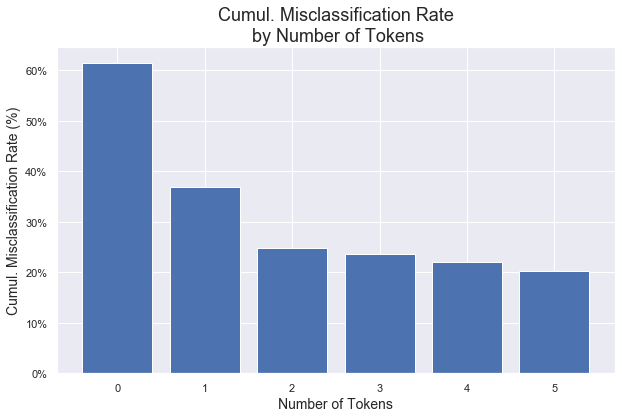

In [264]:
#from the sample, reviews with num_tokens 0, 1, and 3 tokens seem to have the worst misclassification rates.
#However, since the sample for each class is so small, I will assess this data cumulatively...

cum_ms_cls_rate = np.cumsum(samp_perc_df['wrong'])/np.cumsum(samp_perc_df['total']) #cumulative misclassification rate

plt.figure(figsize=(10,6))
plt.bar(x=range(0,6),height=cum_ms_cls_rate)
plt.xlabel('Number of Tokens',fontsize = 14)
plt.ylabel('Cumul. Misclassification Rate (%)',fontsize = 14)
plt.title('Cumul. Misclassification Rate\n by Number of Tokens',fontsize = 18)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

In [256]:
#overall classification accuracy for reviews with 5 or fewer tokens

acc_5below = samp_perc_df['correct'].sum()/samp_perc_df['total'].sum()
acc_5below

0.7979274611398963

In [257]:
#It seems that cumulatively, having 2 tokens and above will give lower misclassification rates (~25% as compared to above 35% for 1 token and below)
#Let's inspect the labelled dataframe and inspect num_tokens at the percentile levels
df_dominant_topic.describe()

,topic_perc_contrib,num_tokens,num_unique_tokens
count,3661.000000,3661.000000,3661.000000
mean,0.684212,13.361923,11.403169
std,0.170385,25.330296,18.677219
min,0.280800,0.000000,0.000000
25%,0.559500,2.000000,2.000000
50%,0.685500,5.000000,5.000000
75%,0.831500,13.000000,12.000000
max,0.993400,342.000000,223.000000


In [282]:
#num_tokens 25th percentile is 2 -- we will have to sacrifice 25% of our dataset in order to use only data that is likely to be classified correctly 
#get class balance; we are going to check the labelling later
df_dominant_topic['dominant_topic'].value_counts(normalize=True)

Content & Authenticity           0.608850
Tactical Gameplay                0.143950
Characters                       0.107348
UX/UI, Performance, Stability    0.075116
Strategic Gameplay               0.064736
Name: dominant_topic, dtype: float64

In [284]:
#There appears to be significant class imbalance, but it is expected. Reviewers tend to talk about how a game lives up to the series and/or genre it is from. 
#We will now sample 10% of the entire dataset at random (approximately 6% margin of error)

topic_weights = df_dominant_topic['dominant_topic']
sample_tokens_df_2 = df_dominant_topic.sample(frac=0.1,random_state=1337)
sample_tokens_df_2.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
2875,Content & Authenticity,The best Total War out there.,0.6664,[best_total_war],1,[best_total_war],1,"three_kingdoms, series, fan, diplomacy, battle..."
1662,Characters,My first time in the total war series. My play...,0.6446,"[series, skip, work, vassal, bugger, yuan_shao]",6,"[series, bugger, work, yuan_shao, skip, vassal]",6,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
3190,Content & Authenticity,Many years ago I asked for Total War set in Ch...,0.9325,"[years_ago, set_china, enjoy, lol, clown, empi...",10,"[enjoy, gaming, graphic, guy, lol, empire, lap...",10,"three_kingdoms, series, fan, diplomacy, battle..."
948,Content & Authenticity,"Great game, great graphics, love the time peri...",0.6613,"[graphic, time_period, needs_work, faction, di...",6,"[faction, time_period, graphic, diplomacy, not...",6,"three_kingdoms, series, fan, diplomacy, battle..."
1541,Content & Authenticity,Big bad Dong is trying to rule China but not o...,0.5832,"[dong, rule_china, one_best]",3,"[one_best, rule_china, dong]",3,"three_kingdoms, series, fan, diplomacy, battle..."


In [285]:
sample_tokens_df_2.to_csv('./dataframes/sample_tokens_df_2.csv')

In [311]:
#import labelled sample_tokens_df

sample_token_2_correct_wrong = pd.read_csv('./dataframes/sample_2_correct_wrong.csv',index_col=None) # saved 'correct' label column as separate column due to UTF-8 encoding issues with Excel

In [312]:
sample_token_2_mod_df=sample_tokens_df_2
sample_token_2_mod_df['correct'] = list(sample_token_2_correct_wrong['correct'])

In [313]:
sample_token_2_mod_df.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords,correct
2875,Content & Authenticity,The best Total War out there.,0.6664,[best_total_war],1,[best_total_war],1,"three_kingdoms, series, fan, diplomacy, battle...",1
1662,Characters,My first time in the total war series. My play...,0.6446,"[series, skip, work, vassal, bugger, yuan_shao]",6,"[series, bugger, work, yuan_shao, skip, vassal]",6,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao...",1
3190,Content & Authenticity,Many years ago I asked for Total War set in Ch...,0.9325,"[years_ago, set_china, enjoy, lol, clown, empi...",10,"[enjoy, gaming, graphic, guy, lol, empire, lap...",10,"three_kingdoms, series, fan, diplomacy, battle...",1
948,Content & Authenticity,"Great game, great graphics, love the time peri...",0.6613,"[graphic, time_period, needs_work, faction, di...",6,"[faction, time_period, graphic, diplomacy, not...",6,"three_kingdoms, series, fan, diplomacy, battle...",1
1541,Content & Authenticity,Big bad Dong is trying to rule China but not o...,0.5832,"[dong, rule_china, one_best]",3,"[one_best, rule_china, dong]",3,"three_kingdoms, series, fan, diplomacy, battle...",1


In [319]:
samp_2_df = sample_token_2_mod_df.groupby(['num_tokens','correct'],as_index=False).count()[['num_tokens','correct','dominant_topic']]
samp_2_df.columns = ['num_tokens','correct','count']
samp_2_count_1_df = samp_2_df.groupby(['correct'],as_index=False).sum()[['correct','count']]
samp_2_count_1_df

,correct,count
0,0,54
1,1,312


In [320]:
#overall misclassification rate

ms_cls_rate2 = samp_2_count_1_df['count'][0]/len(sample_tokens_df_2)
ms_cls_rate2

0.14754098360655737

In [321]:
# groupby for num_tokens > 1

samp_2_count_2_df = samp_2_df[samp_2_df['num_tokens']>1]

samp_2_count_2_df = samp_2_count_2_df.groupby(['correct'],as_index=False).sum()[['correct','count']]
samp_2_count_2_df

,correct,count
0,0,43
1,1,273


In [325]:
#misclassification rate for num_tokens > 1
ms_cls_rate3 = samp_2_count_2_df['count'][0]/(samp_2_count_2_df['count'][0]+samp_2_count_2_df['count'][1])
ms_cls_rate3

0.1360759493670886

In [342]:
#get misclassification percentages for each token class in sample_2

unique_num_tokens = list(samp_2_df['num_tokens'].unique())

samp_2_perc_dict = {'num_tokens':[],'correct':[],'wrong':[],'total':[],'ms_cls_rate (%)':[]}

for i in unique_num_tokens:
    try:
        token_correct = samp_2_df[(samp_2_df['num_tokens']==i)]['count'][samp_2_df['correct']==1].reset_index(drop=True)[0] #returns Series, must convert to scalar
    except IndexError:
        token_correct = 0
    
    token_total = samp_2_df[(samp_2_df['num_tokens']==i)]['count'].sum()
    token_wrong = token_total - token_correct
    samp_2_perc_dict['num_tokens'].append(i)
    samp_2_perc_dict['correct'].append(token_correct)
    samp_2_perc_dict['wrong'].append(token_wrong)
    samp_2_perc_dict['total'].append(token_total)
    samp_2_perc_dict['ms_cls_rate (%)'].append(token_wrong/token_total*100)

samp_2_perc_df = pd.DataFrame(samp_2_perc_dict)

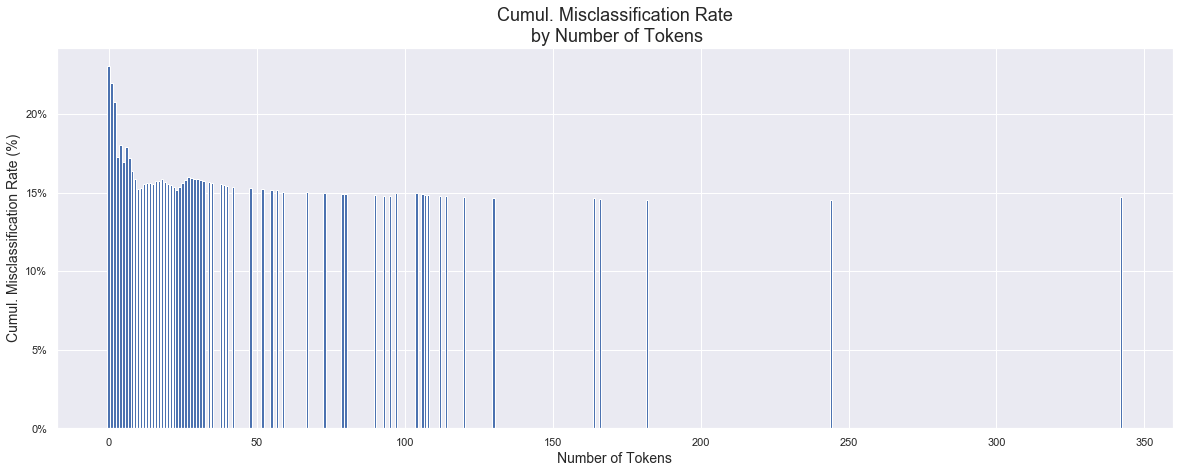

In [412]:
cum_ms_cls_rate = np.cumsum(samp_2_perc_df['wrong'])/np.cumsum(samp_2_perc_df['total']) #cumulative misclassification rate

plt.figure(figsize=(20,7))
plt.bar(x=unique_num_tokens,height=cum_ms_cls_rate)
plt.xlabel('Number of Tokens',fontsize = 14)
plt.ylabel('Cumul. Misclassification Rate (%)',fontsize = 14)
plt.title('Cumul. Misclassification Rate\n by Number of Tokens',fontsize = 18)
_ = plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

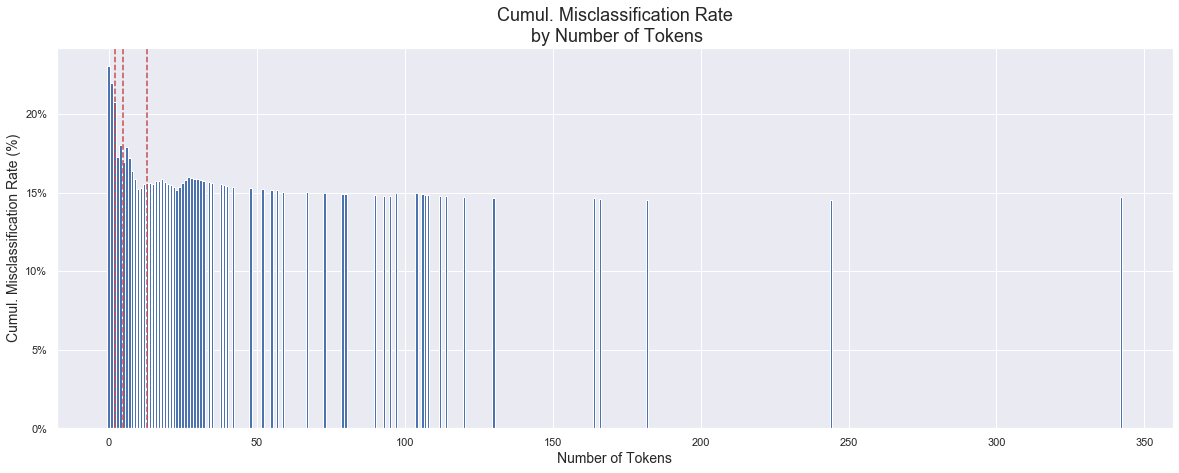

In [413]:
#adding in 3 lines marking the 25th, 50th, and 75th percentiles

cum_ms_cls_rate = np.cumsum(samp_2_perc_df['wrong'])/np.cumsum(samp_2_perc_df['total']) #cumulative misclassification rate

plt.figure(figsize=(20,7))
plt.bar(x=unique_num_tokens,height=cum_ms_cls_rate)
plt.xlabel('Number of Tokens',fontsize = 14)
plt.ylabel('Cumul. Misclassification Rate (%)',fontsize = 14)
plt.title('Cumul. Misclassification Rate\n by Number of Tokens',fontsize = 18)
_ = plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

for i in [25,50,75]:
    plt.axvline(x=int(np.percentile(sample_token_2_mod_df['num_tokens'],i)),color='r',ls='--')

In [384]:
trunc_samp_2_df = samp_2_df[samp_2_df['num_tokens']<=(np.percentile(sample_token_2_mod_df['num_tokens'],80))]

#get misclassification percentages for each token class in sample_2

trunc_unique_num_tokens = list(trunc_samp_2_df['num_tokens'].unique())

trunc_samp_2_perc_dict = {'num_tokens':[],'correct':[],'wrong':[],'total':[],'ms_cls_rate (%)':[]}

for i in trunc_unique_num_tokens:
    try:
        token_correct = trunc_samp_2_df[(trunc_samp_2_df['num_tokens']==i)]['count'][trunc_samp_2_df['correct']==1].reset_index(drop=True)[0] #returns Series, must convert to scalar
        
    except IndexError:
        token_correct = 0
    
    token_total = trunc_samp_2_df[(trunc_samp_2_df['num_tokens']==i)]['count'].sum()
    token_wrong = token_total - token_correct
    trunc_samp_2_perc_dict['num_tokens'].append(i)
    trunc_samp_2_perc_dict['correct'].append(token_correct)
    trunc_samp_2_perc_dict['wrong'].append(token_wrong)
    trunc_samp_2_perc_dict['total'].append(token_total)
    trunc_samp_2_perc_dict['ms_cls_rate (%)'].append(token_wrong/token_total*100)

trunc_samp_2_perc_df = pd.DataFrame(trunc_samp_2_perc_dict)
trunc_samp_2_perc_df

,num_tokens,correct,wrong,total,ms_cls_rate (%)
0,0,10,3,13,23.076923
1,1,29,8,37,21.621622
2,2,41,10,51,19.607843
3,3,35,3,38,7.894737
4,4,17,5,22,22.727273
5,5,20,2,22,9.090909
6,6,13,5,18,27.777778
7,7,13,1,14,7.142857
8,8,11,0,11,0.000000
9,9,12,1,13,7.692308


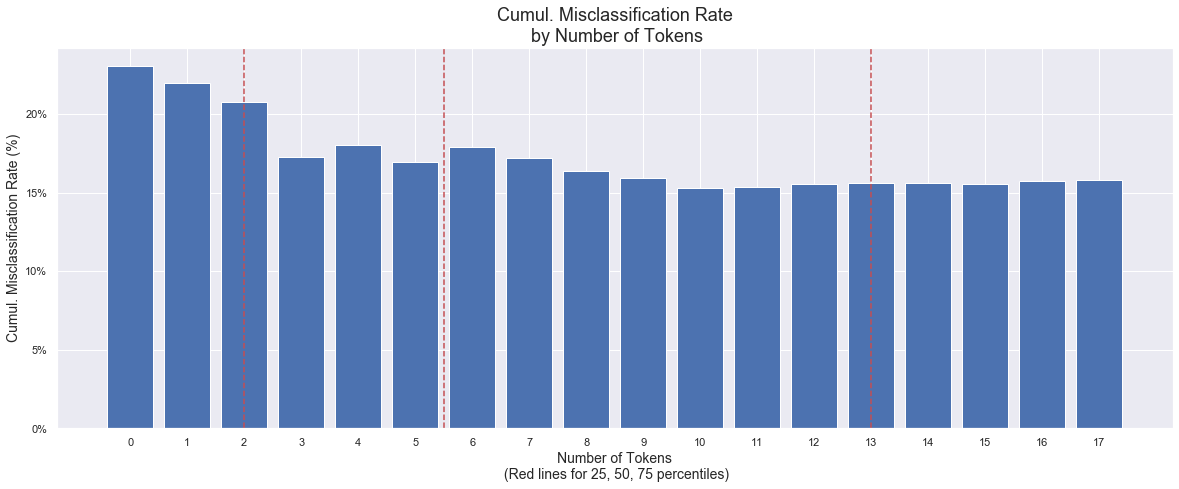

In [411]:
#show only data up to the 25th, 50th, and 80th percentile, with 3 lines marking 25, 50, and 75 percentiles

trunc_cum_ms_cls_rate = np.cumsum(trunc_samp_2_perc_df['wrong'])/np.cumsum(trunc_samp_2_perc_df['total']) #cumulative misclassification rate

plt.figure(figsize=(20,7))
plt.bar(x=trunc_unique_num_tokens, height=trunc_cum_ms_cls_rate)
plt.xticks(np.arange(min(trunc_unique_num_tokens), max(trunc_unique_num_tokens)+1, 1.0))
plt.xlabel('Number of Tokens\n (Red lines for 25, 50, 75 percentiles)',fontsize = 14)
plt.ylabel('Cumul. Misclassification Rate (%)',fontsize = 14)
plt.title('Cumul. Misclassification Rate\n by Number of Tokens',fontsize = 18)
_ = plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

for i in [25,50,75]:
    plt.axvline(x=np.percentile(sample_token_2_mod_df['num_tokens'],i),color='r',ls='--')

In [402]:
#0 tokens -- highest misclassification
#at least 3 tokens -- misclassification rates decrease the most
#Dropping every review with up to 2 tokens may not be viable; that means dropping 25% of the remaining data
#Dropping reviews with 1 and fewer tokens may yield a good balance.
#Overall classification accuracy is ~85% in any case

overall_ms_cls_rates = []

for i in range(10):
    samp_count_df = samp_2_df[samp_2_df['num_tokens']>=i]
    samp_count_df = samp_count_df.groupby(['correct'],as_index=False).sum()
    itr_ms_cls_rate = samp_count_df['count'][0]/samp_count_df['count'].sum()
    overall_ms_cls_rates.append(itr_ms_cls_rate)

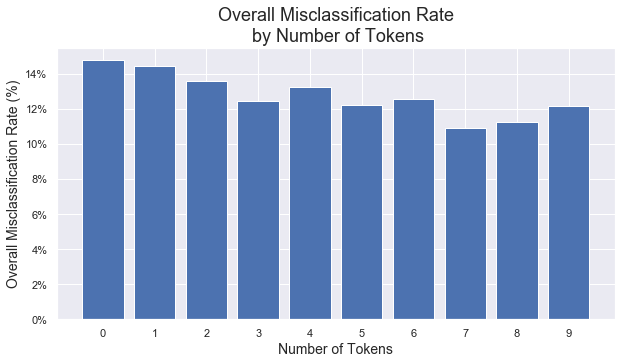

In [428]:
plt.figure(figsize=(10,5))
plt.bar(x=range(10),height=overall_ms_cls_rates)
plt.xticks(range(10))
plt.xlabel('Number of Tokens',fontsize = 14)
plt.ylabel('Overall Misclassification Rate (%)',fontsize = 14)
plt.title('Overall Misclassification Rate\n by Number of Tokens',fontsize = 18)
_ = plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

In [454]:
#find data loss

orig_ln = len(sample_token_2_mod_df)
ln_lst = []
loss_lst = []

for i in range(0,10):
    ln_lst.append(len(sample_token_2_mod_df[sample_token_2_mod_df['num_tokens']>=i]))
    data_loss = [1-(x/orig_ln) for x in ln_lst]

loss_df = pd.DataFrame()
loss_df['num_tokens (x and above)']=range(0,10)
loss_df['overall_ms_cls_rates'] = overall_ms_cls_rates
loss_df['data_loss'] = data_loss
loss_df

,num_tokens (x and above),overall_ms_cls_rates,data_loss
0,0,0.147541,0.000000
1,1,0.144476,0.035519
2,2,0.136076,0.136612
3,3,0.124528,0.275956
4,4,0.132159,0.379781
5,5,0.121951,0.439891
6,6,0.125683,0.500000
7,7,0.109091,0.549180
8,8,0.112583,0.587432
9,9,0.121429,0.617486


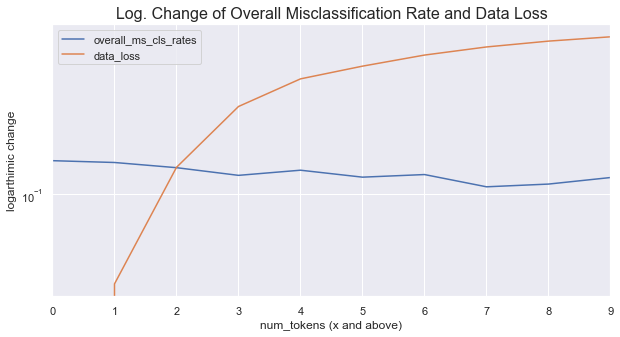

In [456]:
loss_df.plot(x='num_tokens (x and above)',y=['overall_ms_cls_rates','data_loss'],figsize=(10,5),logy=True)    #set Y axis to log scale; easier to see change
_=plt.ylabel('logarthimic change')
_=plt.title('Log. Change of Overall Misclassification Rate and Data Loss',fontsize=16)

### Findings from the Samples

**General Findings**
- Long reviews tend to cover multiple topics. 
    - Classifying a whole review as being about one topic is one way of doing things, but it could mean wasted opportunities.
    - Could be worth analysing the dataset by sentences.</br></br>

**Sample with num_tokens <=5:**
- The cumulative misclassficiation rate of the low token count sample is between 20% (5 tokens) and 60% (0 tokens), which I can accept for text analysis...
    - ... for the Internet is dark and full of errors. 

A classification rate of around 80% classification success rate from an unsupervised model seems quite usable. 


**Sample with any number of tokens:**
- Overall classification accuracy of sample (10% of the whole dataset) is around 86%, which I find quite acceptable. 
    - The rate should be approximately the same for the whole dataset 
    - 5% margin of error according to http://www.raosoft.com/samplesize.html </br></br>
    
- 1 or fewer tokens dropped
    - Misclassification rate drops from ~14.8% to ~13.6%. 
    - We sacrifice 13.7% of the usable data. 
    - Possibly a worthy tradeoff. </br></br>
    
- 2 or fewer tokens dropped
    - Misclassification rate drops from ~13.6% to ~12.5%. 
    - However, we sacrifice 27.6% of the usable data. 
    - The loss of data is too severe to for this to be a worthy tradeoff. </br></br>

**NEXT STEPS**

- Remove reviews that have 0 or 1 tokens from the dataset
    - AFTER sentiment analysis 
    - model was trained on this dataset
    - Low token count reviews should be dropped only after all the model has been reloaded and topic assignment has been done (retroactively discovered this)
- Analyse the entire corpus by sentences instead of by document.
    - This way, there will be more data overall; long reviews can be broken down into parts that talk about different topics. 
- The resulting topics and sentiments can be grouped together for a more accurate overview of player sentiment overall, rather than sentiment for the dominant topic of each document

In [457]:
#Remove reviews with 1 or 0 tokens

#df_dominant_topic2=df_dominant_topic[df_dominant_topic['num_tokens']>1]

#Find out what proportion of reviews were dropped
#rows_removed = abs(len(df_dominant_topic)-len(df_dominant_topic2))/len(df_dominant_topic)
#print(rows_removed)

0.15542201584266593


In [458]:
#Get number of reviews remaining

#len(df_dominant_topic2)

3092

In [463]:
# df_dominant_topic2.to_csv('./dataframes/dominant_topics.csv')
df_dominant_topic.to_csv('./dataframes/dominant_topics.csv')

In [462]:
len(df_dominant_topic)

3661